# Compare cell lines 

In [1]:
import sys
import pandas as pd 
import numpy as np
from glob import glob
from matplotlib.pyplot import subplots
from itertools import chain
from functools import reduce
from venn import venn

sys.path.append('/rumi/shams/abe/GitHub/Abe/my_scripts/')

import ipage_down 
from ipage_down import *

Redo ipage

In [19]:
ls hl60-exp/

hl60-exp/120h_delta_exp.txt_PAGE:
120h_delta_exp.txt.summary.eps  input.ipage_quantized       pvmatrix.txt.log
120h_delta_exp.txt.summary.pdf  output.ipage_intersections
info.txt                        pvmatrix.txt

hl60-exp/6h_delta_exp.txt_PAGE:
6h_delta_exp.txt.summary.eps  input.ipage_quantized       pvmatrix.txt.log
6h_delta_exp.txt.summary.pdf  output.ipage_intersections
info.txt                      pvmatrix.txt


In [32]:
!basename --help

Usage: basename NAME [SUFFIX]
  or:  basename OPTION... NAME...
Print NAME with any leading directory components removed.
If specified, also remove a trailing SUFFIX.

Mandatory arguments to long options are mandatory for short options too.
  -a, --multiple       support multiple arguments and treat each as a NAME
  -s, --suffix=SUFFIX  remove a trailing SUFFIX; implies -a
  -z, --zero           end each output line with NUL, not newline
      --help     display this help and exit
      --version  output version information and exit

Examples:
  basename /usr/bin/sort          -> "sort"
  basename include/stdio.h .h     -> "stdio"
  basename -s .h include/stdio.h  -> "stdio"
  basename -a any/str1 any/str2   -> "str1" followed by "str2"

GNU coreutils online help: <http://www.gnu.org/software/coreutils/>
Full documentation at: <http://www.gnu.org/software/coreutils/basename>
or available locally via: info '(coreutils) basename invocation'


In [34]:
!basename -a `ls *-{exp,stbl}/*_PAGE` | grep _PAGE

ls: cannot access '*-stbl/*_PAGE': No such file or directory
120h_delta_exp.txt_PAGE:
6h_delta_exp.txt_PAGE:
kg1_delta_exp.txt_PAGE:
molm14_delta_exp.txt_PAGE:
ociaml2_delta_exp.txt_PAGE:
ociaml3_delta_exp.txt_PAGE:
thp1_delta_exp.txt_PAGE:


In [17]:
%%bash 
for f in `ls *-{exp,stbl}/*_delta_{exp,stbl}.txt`; do 
    nohup ls $f | parallel -j18 -k bash ipage_human_ensembl.sh {} &> ipage.out &
done 

ls: cannot access '*-exp/*_delta_stbl.txt': No such file or directory
ls: cannot access '*-stbl/*_delta_exp.txt': No such file or directory


## Pairwise correlations:

In [25]:
path_to_cells_rnaseq = glob.glob('*-exp/*_delta_exp_table.txt')
cell_names = [p.split('/')[1].replace('_delta_exp_table','').replace('.txt','').replace('_','') for p in path_to_cells_rnaseq]
all_cells_rnaseq = [
    [name, pd.read_csv(path, sep='\t', header = 0, index_col=0)] for path, name in 
    zip(path_to_cells_rnaseq, cell_names)
]
# all DESeq result tables 
data = dict(all_cells_rnaseq)

# make dataframe of log2FC values for each experiment 
hl60_df = data['hl60'].filter(like='log2FC', axis=1)
hl60_df.columns = hl60_df.columns.str.replace("log2FC", "hl60")

df = pd.concat([data[k].log2FoldChange for k in data.keys() if k !='hl60'],
          axis=1).loc[data['hl60'].index.tolist()]
df.columns=[k for k in data.keys() if k !='hl60']
df = pd.concat([df,hl60_df],axis=1)

https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

In [141]:
# df.corr().style.background_gradient(cmap='coolwarm',axis=None)

In [112]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns


def plot_corr(df):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    alpha = df.columns.values
    cax = ax.matshow(df.corr(), interpolation='nearest')
    fig.colorbar(cax)

    xaxis = np.arange(len(alpha))
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)

    ax.set_xticklabels(alpha, rotation=45)
    ax.set_yticklabels(alpha, rotation=45)

    plt.show()
#     corr = df.corr()
#     sns.heatmap(corr, 
#                 xticklabels=corr.columns.values,
#                 yticklabels=corr.columns.values)

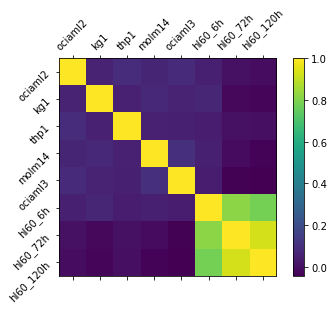

In [113]:
plot_corr(df)

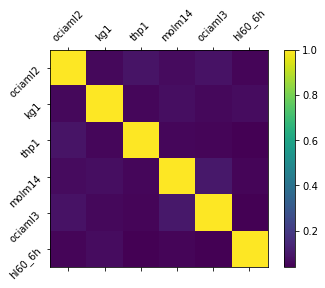

In [114]:
plot_corr(
    pd.concat([
    df.iloc[:,range(5)], 
    df.iloc[:,5] ], 
    axis=1)
)

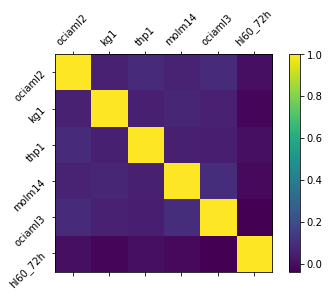

In [115]:
plot_corr(
    pd.concat([
    df.iloc[:,range(5)], 
    df.iloc[:,6] ], 
    axis=1)
)

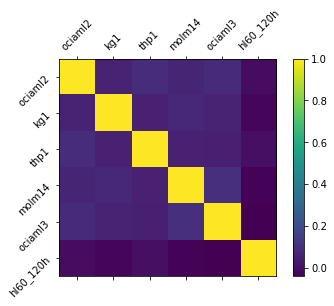

In [116]:
plot_corr(
    pd.concat([
    df.iloc[:,range(5)], 
    df.iloc[:,7] ], 
    axis=1)
)

## Pathway enrichment consistency across cell lines 
iPAGE results. 

In [2]:
help(ipage_down)

Help on module ipage_down:

NAME
    ipage_down

FUNCTIONS
    make_page_dict(PATH)
        PATH = a complete path to a pvmatrix.txt file, part of results from iPAGE run 
        
        Processes: 
        1) Read p-value matrix data into a data frame
        2) Include annotations for the gene set from the PAGE directory
        
        Output: Python dictionary contain pvmatrix and related annotations to the gene set
    
    read_gmt(PATH)
        Read given gmt file into a Dictionary
    
    read_page_annotations(gs_name, ANNDIR='/flash/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/')
        Read gene set annotations into python from PAGE_DATA format
    
    read_page_index(PATH)
        Read given *index.txt files into a Dictionary
    
    read_page_names(PATH)
        Read given *name.txt files into a Dictionary

FILE
    /rumi/shams/abe/GitHub/Abe/my_scripts/ipage_down.py




___
- Clean up iPAGE results with no signal

In [25]:
%%bash 
for pv in `ls *-stbl/*_delta_stbl/*/pvmatrix.*.txt`; do 
    b=`basename $pv`; b=${b/pvmatrix./};b=${b/.txt/}
    if  [ "$(wc -l < $pv)" -eq "$(echo '1')" ]; then 
        echo `dirname $pv` $b NO SIGNAL!
        rm -v $pv
    elif [ "$(wc -l < $pv)" -eq "$(echo '0')" ]; then 
        echo `dirname $pv` $b NO DATA!
        rm -v $pv
    else
        echo `dirname $pv` $b `cat $pv | wc -l`
    fi
    echo '------------'
done 

hl60-stbl/120h_delta_stbl/human_ensembl_encode_tf all NO SIGNAL!
removed 'hl60-stbl/120h_delta_stbl/human_ensembl_encode_tf/pvmatrix.all.txt'
------------
hl60-stbl/120h_delta_stbl/human_ensembl_encode_tf L NO SIGNAL!
removed 'hl60-stbl/120h_delta_stbl/human_ensembl_encode_tf/pvmatrix.L.txt'
------------
hl60-stbl/120h_delta_stbl/human_ensembl_encode_tf R NO SIGNAL!
removed 'hl60-stbl/120h_delta_stbl/human_ensembl_encode_tf/pvmatrix.R.txt'
------------
hl60-stbl/120h_delta_stbl/human_ensembl_msigdb_c1 all 3
------------
hl60-stbl/120h_delta_stbl/human_ensembl_msigdb_c1 L NO SIGNAL!
removed 'hl60-stbl/120h_delta_stbl/human_ensembl_msigdb_c1/pvmatrix.L.txt'
------------
hl60-stbl/120h_delta_stbl/human_ensembl_msigdb_c1 R NO SIGNAL!
removed 'hl60-stbl/120h_delta_stbl/human_ensembl_msigdb_c1/pvmatrix.R.txt'
------------
hl60-stbl/120h_delta_stbl/human_ensembl_msigdb_c2 all 15
------------
hl60-stbl/120h_delta_stbl/human_ensembl_msigdb_c2 L 5
------------
hl60-stbl/120h_delta_stbl/human_ens

In [130]:
def get_enriched(pvmatrixfile,experiment='exp'):
    paths = glob(f'*-{experiment}/*_delta_{experiment}/*/{pvmatrixfile}')

    out = {} 
    for f in paths:
        if 'other' in f:
            key = f.split('/')[1].replace(f'_delta_{experiment}','')
        if 'other' not in f:
            key = 'hl60_'+f.split('/')[1].replace(f'_delta_{experiment}','')
        
        if key in out.keys():
            out[key] = out[key] + make_page_dict(f)['data'].index.tolist()
        else:
            out[key] = make_page_dict(f)['data'].index.tolist()
        
    for key in out.keys():
        out[key] = set(out[key])
    
    return out

Exp_down = get_enriched('pvmatrix.L.txt')
del Exp_down['hl60_6h']
del Exp_down['hl60_72h']
Exp_up = get_enriched('pvmatrix.R.txt')
del Exp_up['hl60_6h']
del Exp_up['hl60_72h']

Stbl_down = get_enriched('pvmatrix.L.txt','stbl')
del Stbl_down['hl60_6h']

Stbl_up = get_enriched('pvmatrix.R.txt','stbl')
del Stbl_up['hl60_6h']


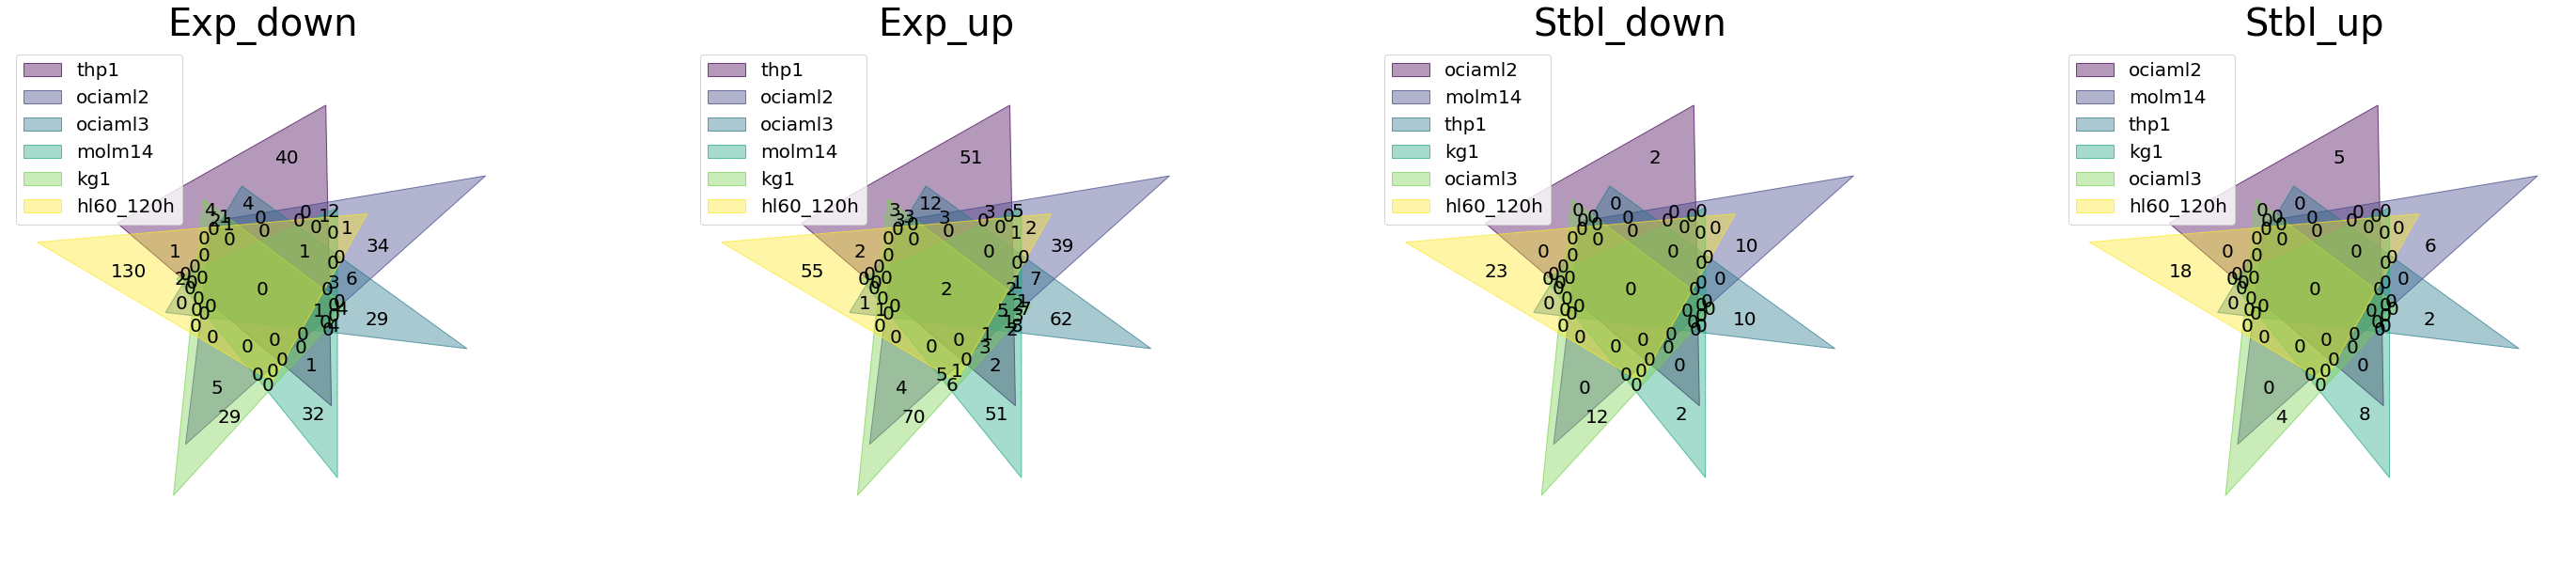

In [158]:
studies = ['Exp_down', 'Exp_up', 'Stbl_down', 'Stbl_up']

_, axs = subplots(ncols=4, nrows=1, figsize=(50, 10))

for std,ax in zip(studies,chain(axs, )):

    venn(eval(std),fontsize=20,legend_loc="upper left",  ax=ax)
    ax.set_title(std,fontsize=40)

In [167]:
reduce(set.intersection, Exp_up.values())

{'GO:0007156 homophilic cell adhesion via plasma membrane adhesion molecules',
 'GO_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT'}

- https://gseapy.readthedocs.io/en/latest/
- https://pypi.org/project/gsea-api/

In [256]:
msigdb_c5 = read_gmt('/rumi/shams/abe/Datasets/MSigDB/msigdb_v7.2_GMTs/c5.all.v7.2.symbols.gmt')

In [259]:
len(msigdb_c5['GO_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT']['genes'])

169

In [262]:
len(msigdb_c5['GO_HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHESION_MOLECULES']['genes'])

168